In [490]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [491]:
DEVICE

device(type='cuda', index=0)

In [492]:
from zipfile import ZipFile
zip = ZipFile('DATA_TRAIN.zip')
zip.namelist()

['DATA_TRAIN/',
 'DATA_TRAIN/data_train_im/',
 'DATA_TRAIN/data_train_im/train_0.png',
 'DATA_TRAIN/data_train_im/train_1.png',
 'DATA_TRAIN/data_train_im/train_10.png',
 'DATA_TRAIN/data_train_im/train_11.png',
 'DATA_TRAIN/data_train_im/train_12.png',
 'DATA_TRAIN/data_train_im/train_13.png',
 'DATA_TRAIN/data_train_im/train_14.png',
 'DATA_TRAIN/data_train_im/train_15.png',
 'DATA_TRAIN/data_train_im/train_16.png',
 'DATA_TRAIN/data_train_im/train_17.png',
 'DATA_TRAIN/data_train_im/train_18.png',
 'DATA_TRAIN/data_train_im/train_19.png',
 'DATA_TRAIN/data_train_im/train_2.png',
 'DATA_TRAIN/data_train_im/train_20.png',
 'DATA_TRAIN/data_train_im/train_21.png',
 'DATA_TRAIN/data_train_im/train_3.png',
 'DATA_TRAIN/data_train_im/train_4.png',
 'DATA_TRAIN/data_train_im/train_5.png',
 'DATA_TRAIN/data_train_im/train_6.png',
 'DATA_TRAIN/data_train_im/train_7.png',
 'DATA_TRAIN/data_train_im/train_8.png',
 'DATA_TRAIN/data_train_im/train_9.png',
 'DATA_TRAIN/data_train_lab/',
 'DATA_TR

In [341]:
!unzip DATA_TRAIN.zip

Archive:  TRAIN_DS_2.zip
replace TRAIN_DS_2/data_train_im/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.8 MB/s 


In [ ]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [ ]:
sm.set_framework('tf.keras')

In [285]:
# loading image data...
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [493]:
image_dataset = data_loader('DATA_TRAIN/data_train_im/')

In [494]:
len(image_dataset)

22

In [495]:
image_dataset[0].shape

(128, 128, 3)

In [496]:
mask_dataset = data_loader('DATA_TRAIN/data_train_lab/')

In [497]:
len(mask_dataset)

22

In [498]:
mask_dataset[0].shape

(128, 128, 3)

In [499]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 42) # train test split for data...

In [500]:
def augmentation(dataset):
    image_dataset = []
    ANGLES = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 15, 30]
    
    for image in dataset:
        rows, cols, _ = image.shape
        for angle in ANGLES:
            M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0), angle, 1)
            dst = cv2.warpAffine(image, M, (cols,rows))
            #dst = dst[10:rows-10, 10:cols-10]
            
            image_dataset.append(dst)
    return image_dataset

In [501]:
X_train = augmentation(X_train)
y_train = augmentation(y_train)
X_test = augmentation(X_test)
y_test = augmentation(y_test)

In [502]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [503]:
X_train.shape

(221, 128, 128, 3)

In [504]:
X_train.shape

(221, 128, 128, 3)

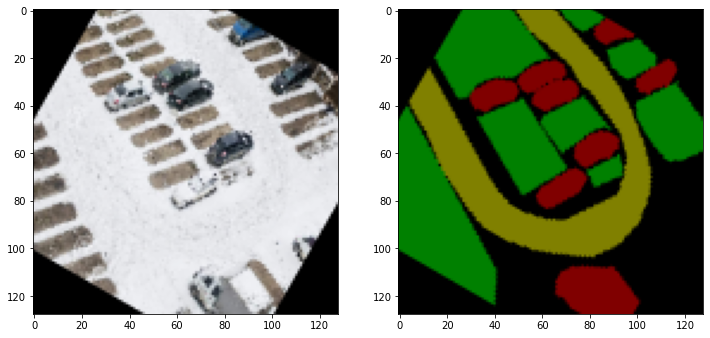

In [505]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(y_train[image_number])
plt.show()

In [511]:
'''
For the Dataset-2
'''
# d = {'name': ['Unlabelled','Car', 'Parking'], 'r': [0,128,0], 'g': [0,0, 128], 'b': [0,0,0], 'label': [0, 1, 2]}
#n_classes = 3
# mask_labels = pd.DataFrame(data=d)
# mask_labels

'''
For the Dataset-1
'''
d = {'name': ['Unlabelled','Car', 'Mud', 'Parking', 'Road'], 'r': [0,128,0,128,0], 'g': [0,0, 128, 128, 0], 'b': [0,0,0,0,128], 'label': [0, 1, 2, 3, 4]}
n_classes = 5
mask_labels = pd.DataFrame(data=d)
mask_labels

,name,r,g,b,label
0,Unlabelled,0,0,0,0
1,Car,128,0,0,1
2,Mud,0,128,0,2
3,Parking,128,128,0,3
4,Road,0,0,128,4


In [512]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [513]:
def get_labels(mask_dataset):
    labels = []
    for i in range(mask_dataset.shape[0]):
        label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
        labels.append(label)
    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3) # adding channel dim...
    return labels

In [514]:
labels_train = get_labels(y_train)
labels_test = get_labels(y_test)

Unique labels in label dataset are:  [0 1 2 3 4]


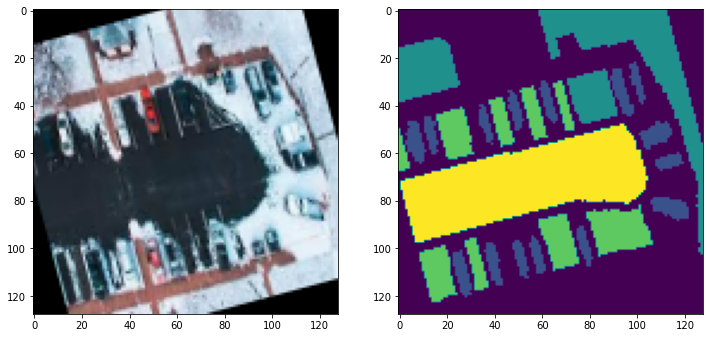

In [515]:
print("Unique labels in label dataset are: ", np.unique(labels_train))

#Another Sanity check...
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(labels_train[image_number][:,:,0])
plt.show()

In [516]:
y_train = to_categorical(labels_train, num_classes=n_classes) # one hot encoding the labels...
y_test = to_categorical(labels_test, num_classes=n_classes) # one hot encoding the labels...

In [517]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [518]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [519]:
# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

In [520]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [521]:
model_resnet_backbone.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_204 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                         

In [522]:
# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=8, #16
          epochs=100, #100
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
28/28 [==============================] - 8s 107ms/step - loss: 1.3101 - accuracy: 0.4460 - val_loss: 6.9806 - val_accuracy: 0.3680
Epoch 2/100
28/28 [==============================] - 2s 74ms/step - loss: 0.9726 - accuracy: 0.5952 - val_loss: 30.3732 - val_accuracy: 0.1893
Epoch 3/100
28/28 [==============================] - 2s 69ms/step - loss: 0.7837 - accuracy: 0.6867 - val_loss: 2.7698 - val_accuracy: 0.3127
Epoch 4/100
28/28 [==============================] - 2s 69ms/step - loss: 0.6904 - accuracy: 0.7354 - val_loss: 19.6585 - val_accuracy: 0.3066
Epoch 5/100
28/28 [==============================] - 2s 68ms/step - loss: 0.6117 - accuracy: 0.7658 - val_loss: 1.6548 - val_accuracy: 0.4867
Epoch 6/100
28/28 [==============================] - 2s 69ms/step - loss: 0.5354 - accuracy: 0.7943 - val_loss: 2.6771 - val_accuracy: 0.4315
Epoch 7/100
28/28 [==============================] - 2s 68ms/step - loss: 0.4370 - accuracy: 0.8313 - val_loss: 1.5832 - val_accuracy: 0.5364
Epo

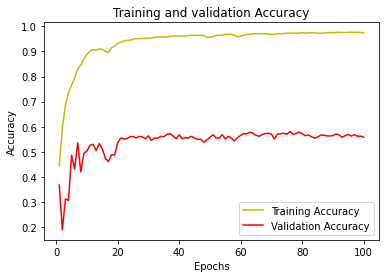

In [523]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [524]:
model_resnet_backbone.save('resnet_backbone_v2.hdf5')

In [525]:
model = load_model('resnet_backbone_v2.hdf5') # loading model...

In [526]:
model = model_resnet_backbone

In [527]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 [==============================] - 1s 53ms/step


In [582]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 22ms/step


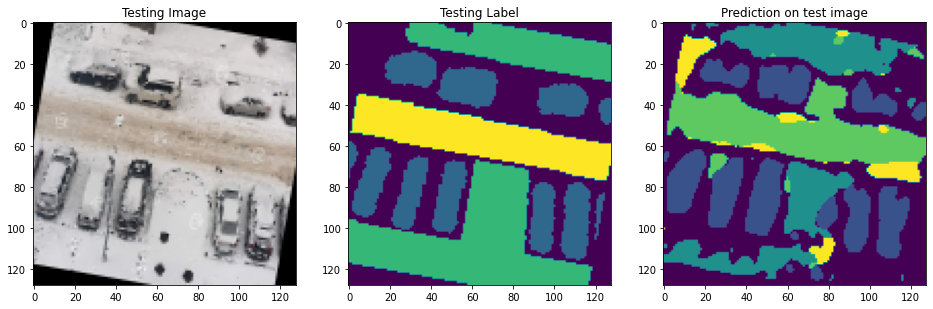

In [583]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [321]:
image = cv2.imread('original_1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))
image = Image.fromarray(image)
image = np.array(image)

In [ ]:
#image = image_dataset[36]

In [ ]:
test_img_input=np.expand_dims(image, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 24ms/step


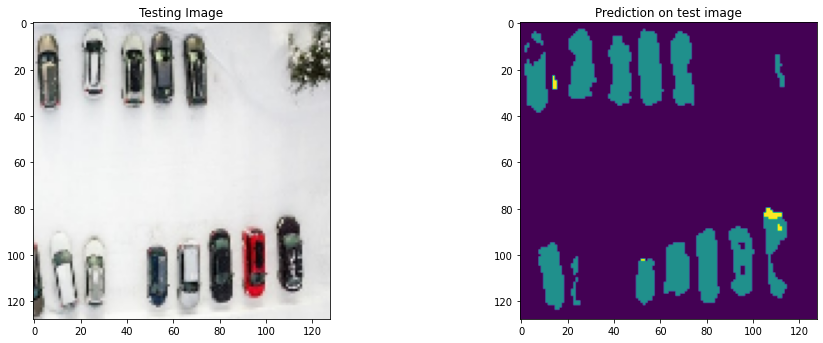

In [ ]:
bplt.figure(figsize=(16, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(image)
plt.subplot(222)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
def label_to_rgb(predicted_img):
    res = np.zeros((128, 128, 3))
    for i in range(128):
        for j in range(128):
            l = predicted_img[i][j]
            if l % 2 == 1:
                res[i][j][0] = 255
            if l == 2 or l == 3:
                res[i][j][1] = 255
            if l == 4:
                res[i][j][2] = 255
    return res


In [ ]:
masked_to_save = label_to_rgb(predicted_img)

In [ ]:
cv2.imwrite("segmented_6.jpg", masked_to_save)

True

In [ ]:
#!unzip Test.zip

In [ ]:
cv2.imread('./Test/test_0.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128))
image = Image.fromarray(image)
image = np.array(image)